In [1]:
import numpy as np
#import tensorflow as tf
#from tensorflow.python.client import device_lib
import pandas as pd
from zipfile import ZipFile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from skimage import exposure
#from skimage.color import rgb2gray
import platform
import sys
from datetime import datetime
import random
%matplotlib inline

In [2]:

c = ['center','left','right', 'steer', 'throttle', 'break', 'speed']
samples = np.empty((0, 4))
nlabels = 0
#for s in range(1, input_sessions+1):
#for s in [7, 8]:
for s in [3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]:
    # read CSV file with steering angle

    csvdata = pd.read_csv("./data/driving_{:0>2d}.csv".format(s), header=None, names=c)
    # remove too low speed == car almost stopped
    csvdata = csvdata[csvdata['speed'] >= 0.05]
    
    #print(csvdata.head(5))
    
    nl = csvdata.shape[0]
    nlabels += nl
    n_ = np.vectorize(lambda x: 'driving_{:0>2d}'.format(s))

    # temporary var
    tmp = csvdata.iloc[:, [0, 3]].values
    tmp = np.concatenate((tmp, np.zeros((nl, 1))), axis=1)
    tmp = np.concatenate((tmp, n_(np.ones((nl, 1)))), axis=1)
    
    # duplicate (flip images)
    tmp = np.concatenate((tmp, tmp), axis=0)
    tmp[:nl, 2] = 0 # first half
    tmp[nl:, 2] = 1 # second half
    
    # concatenate
    samples = np.concatenate((samples, tmp), axis=0)
    
    # left
    left = csvdata.iloc[:, [1, 3]].values
    left = np.concatenate((left, np.zeros((nl, 1))), axis=1)
    left = np.concatenate((left, n_(np.ones((nl, 1)))), axis=1)
    left[:, 1] += 0.225
    
    # concatenate
    samples = np.concatenate((samples, left), axis=0)
    
    # right
    right = csvdata.iloc[:, [2, 3]].values
    right = np.concatenate((right, np.zeros((nl, 1))), axis=1)
    right = np.concatenate((right, n_(np.ones((nl, 1)))), axis=1)
    right[:, 1] -= 0.225
    
    # concatenate
    samples = np.concatenate((samples, right), axis=0)
    
    
# total samples
print(samples.shape)

# remove some data when the steering is zero (20%)
#rem_indices = np.nonzero(samples[:, 1] == 0.0)
#n = sum(1 for x in rem_indices[0])
#for i in random.sample(rem_indices[0].tolist(), int(n*0.2)):
#    samples = np.delete(samples, (i), axis=0)
#
#print(samples.shape)

# original shape
owidth = 320
oheight = 160

# crop
stripetop = 55
stripebot = 20

def generator(samples, batch_size=32):
    num_samples = len(samples)
    # 
    # Loop forever so the generator never terminates
    #  but it only executes when code calls "next()"
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                filep = batch_sample[0].split('/')
                name = './data/' + batch_sample[3] + '/' + filep[-1]
                #center_image = cv2.imread(name)
                center_image = mpimg.imread(name, format='jpeg')
                center_angle = float(batch_sample[1])
                
                if batch_sample[2]:
                    # flip image
                    center_image = np.fliplr(center_image)
                    center_angle = -center_angle
                
                # train data
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# 
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#print(train_samples)

# Python automatically interprets the function as generator, and WON'T execute it right away
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
# 
print(train_generator)

(63696, 4)
<generator object generator at 0x7f4ad536d888>


In [3]:
print(len(train_samples))
print(samples[0])

50956
[ '/Users/bgcarvalho/Documents/Personal/pos_nanodegree_SDC/CarND-Term1-P3/data/IMG/center_2017_10_26_21_59_46_606.jpg'
 0.0 0 'driving_03']


# Model Architecture

The proposed model has 5 convolutional layers and 4 fully connected.

In [4]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.layers import Cropping2D
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import __version__ as keras_version
import h5py

Using TensorFlow backend.


In [5]:
model = Sequential()

# CROP images
model.add(Cropping2D(cropping=((stripetop, stripebot), (0,0)), input_shape=(oheight, owidth, 3)))

# normalization and mean centering
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(Conv2D( 24, (7, 7), strides=(2, 2), activation='relu'))
model.add(Conv2D( 36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D( 48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D( 60, (5, 5), activation='relu'))
model.add(Conv2D( 72, (3, 3), activation='relu'))

model.add(Dropout(0.5))

model.add(Flatten())

# layer 6
model.add(Dense(72, activation='relu'))

# layer 7
model.add(Dense(60, activation='relu'))

# layer 8
model.add(Dense(48, activation='relu'))

# layer 9
model.add(Dense(1, name='steer_angle'))

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 85, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 85, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 157, 24)       3552      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 33, 60)         72060     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 31, 72)         38952     
__________

In [7]:
ee = 1e-3
cb_earlystop = EarlyStopping(min_delta=ee, patience=2, verbose=1)

# learning rate and decay over time
opt = optimizers.Adam(lr=0.001, decay=1e-4)

# compile model
model.compile(loss='mse', optimizer=opt)

# train
# samples_per_epoch=len(train_samples),
history = model.fit_generator(train_generator, 
                              steps_per_epoch=len(train_samples)/320,
                              #steps_per_epoch=10,
                              validation_data=validation_generator,
                              validation_steps=len(validation_samples)/320,
                              epochs=20,
                              verbose=1,
                              callbacks=[cb_earlystop]
                             )
# save to disk
model.save('model.h5')


Epoch 1/20
160/159 [==============================] - 14s - loss: 0.0523 - val_loss: 0.0428
Epoch 2/20
160/159 [==============================] - 12s - loss: 0.0476 - val_loss: 0.0419
Epoch 3/20
160/159 [==============================] - 13s - loss: 0.0442 - val_loss: 0.0408
Epoch 4/20
160/159 [==============================] - 12s - loss: 0.0397 - val_loss: 0.0376
Epoch 5/20
160/159 [==============================] - 13s - loss: 0.0404 - val_loss: 0.0434
Epoch 6/20
160/159 [==============================] - 12s - loss: 0.0388 - val_loss: 0.0363
Epoch 7/20
160/159 [==============================] - 12s - loss: 0.0363 - val_loss: 0.0340
Epoch 8/20
160/159 [==============================] - 12s - loss: 0.0327 - val_loss: 0.0367
Epoch 9/20
160/159 [==============================] - 12s - loss: 0.0354 - val_loss: 0.0341
Epoch 10/20
160/159 [==============================] - 12s - loss: 0.0339 - val_loss: 0.0321
Epoch 11/20
160/159 [==============================] - 12s - loss: 0.0297 - val

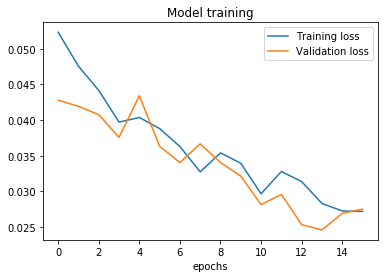

In [8]:
#print(history.history)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('')
plt.title('Model training')
plt.legend(['Training loss', 'Validation loss'])